In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 生成数据集
X1 = torch.rand(10000,1) # 输入特征 1
X2 = torch.rand(10000,1) # 输入特征 2
X3 = torch.rand(10000,1) # 输入特征 3
Y1 = ( (X1+X2+X3)<1 ).float() # 输出特征 1
Y2 = ( (1<(X1+X2+X3)) & ((X1+X2+X3)<2) ).float() # 输出特征 2
Y3 = ( (X1+X2+X3)>2 ).float() # 输出特征 3
Data = torch.cat([X1,X2,X3,Y1,Y2,Y3],axis=1) # 整合数据集
Data = Data.to('cuda:0') # 把数据集搬到 GPU 上
Data.shape

torch.Size([10000, 6])

In [4]:
# 划分训练集与测试集
train_size = int(len(Data) * 0.7) # 训练集的样本数量
test_size = len(Data) - train_size # 测试集的样本数量
Data = Data[torch.randperm( Data.size(0)) , : ] # 打乱样本的顺序
train_Data = Data[ : train_size , : ] # 训练集样本
test_Data = Data[ train_size : , : ] # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

In [5]:
Data

tensor([[0.2614, 0.9666, 0.3021, 0.0000, 1.0000, 0.0000],
        [0.1509, 0.5201, 0.0075, 1.0000, 0.0000, 0.0000],
        [0.7836, 0.7182, 0.7921, 0.0000, 0.0000, 1.0000],
        ...,
        [0.8073, 0.3369, 0.3277, 0.0000, 1.0000, 0.0000],
        [0.7152, 0.2557, 0.3089, 0.0000, 1.0000, 0.0000],
        [0.6135, 0.4468, 0.1445, 0.0000, 1.0000, 0.0000]], device='cuda:0')

In [6]:
class DNN(nn.Module):
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential( # 按顺序搭建各层
        nn.Linear(3, 5), nn.ReLU(), # 第 1 层：全连接层
        nn.Linear(5, 5), nn.ReLU(), # 第 2 层：全连接层
        nn.Linear(5, 5), nn.ReLU(), # 第 3 层：全连接层
        nn.Linear(5, 3) # 第 4 层：全连接层
        )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [7]:
model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [8]:
for name, param in model.named_parameters():
    print(f"参数:{name}\n 形状:{param.shape}\n 数值:{param}\n")

参数:net.0.weight
 形状:torch.Size([5, 3])
 数值:Parameter containing:
tensor([[ 0.4564,  0.5106,  0.5648],
        [-0.0297, -0.1645, -0.2583],
        [ 0.5021, -0.4991, -0.1669],
        [ 0.2241, -0.2996, -0.2610],
        [ 0.0284,  0.3752,  0.0544]], device='cuda:0', requires_grad=True)

参数:net.0.bias
 形状:torch.Size([5])
 数值:Parameter containing:
tensor([-0.3904,  0.2794,  0.1308, -0.0296, -0.5600], device='cuda:0',
       requires_grad=True)

参数:net.2.weight
 形状:torch.Size([5, 5])
 数值:Parameter containing:
tensor([[ 0.2304,  0.3827, -0.2625, -0.1244, -0.1185],
        [-0.3217, -0.2610,  0.3101, -0.0346, -0.2354],
        [ 0.1941,  0.2730, -0.3572, -0.2820,  0.3145],
        [-0.1424,  0.0262,  0.0234, -0.1641,  0.0624],
        [ 0.3492,  0.0117, -0.4221,  0.0400,  0.0580]], device='cuda:0',
       requires_grad=True)

参数:net.2.bias
 形状:torch.Size([5])
 数值:Parameter containing:
tensor([ 0.4356,  0.1052,  0.3796, -0.3760,  0.1271], device='cuda:0',
       requires_grad=True)

参数:net.

In [9]:
# 损失函数的选择
loss_fn = nn.MSELoss()

In [10]:
# 优化算法的选择
learning_rate = 0.01 # 设置学习率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

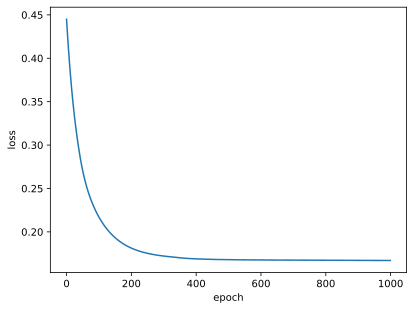

In [11]:
# 训练网络
epochs = 1000
losses = [] # 记录损失函数变化的列表
# 给训练集划分输入与输出
X = train_Data[ : , :3 ] # 前 3 列为输入特征
Y = train_Data[ : , -3: ] # 后 3 列为输出特征
for epoch in range(epochs):
 Pred = model(X) # 一次前向传播（批量）
 loss = loss_fn(Pred, Y) # 计算损失函数
 losses.append(loss.item()) # 记录损失函数的变化
 optimizer.zero_grad() # 清理上一轮滞留的梯度
 loss.backward() # 一次反向传播
 optimizer.step() # 优化内部参数
 
Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss'), plt.xlabel('epoch')
plt.show()

In [12]:
# 测试网络
# 给测试集划分输入与输出
X = test_Data[:, :3]  # 前 3 列为输入特征
Y = test_Data[:, -3:]  # 后 3 列为输出特征
with torch.no_grad():  # 该局部关闭梯度计算功能
    Pred = model(X)  # 一次前向传播（批量）
    Pred[:, torch.argmax(Pred, axis=1)] = 1
    Pred[Pred != 1] = 0
    correct = torch.sum((Pred == Y).all(1))  # 预测正确的样本
    total = Y.size(0)  # 全部的样本数量
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 65.93333435058594 %


In [13]:
# 测试网络
# 给测试集划分输入与输出
X = test_Data[:, :3]  # 前 3 列为输入特征
Y = test_Data[:, -3:]  # 后 3 列为输出特征
with torch.no_grad():  # 该局部关闭梯度计算功能
    Pred = model(X)  # 一次前向传播（批量）
    Pred[:, torch.argmax(Pred, axis=1)] = 1
    Pred[Pred != 1] = 0
    print(Pred.type(), Y.type())   
    print(Pred.shape, Y.shape)     
    print((Pred == Y).type(), (Pred == Y).all(1).type())   
    print((Pred == Y).shape, (Pred == Y).all(1).shape)  
    correct = torch.sum((Pred == Y).all(1))  # 预测正确的样本
    total = Y.size(0)  # 全部的样本数量
print(f'测试集精准度: {100*correct/total} %')

torch.cuda.FloatTensor torch.cuda.FloatTensor
torch.Size([3000, 3]) torch.Size([3000, 3])
torch.cuda.BoolTensor torch.cuda.BoolTensor
torch.Size([3000, 3]) torch.Size([3000])
测试集精准度: 65.93333435058594 %


In [14]:
# 保存网络
torch.save(model, 'model.pth')

In [15]:
# 把模型赋给新网络
new_model = torch.load('model.pth')

In [16]:
# 测试网络
# 给测试集划分输入与输出
X = test_Data[:, :3] # 前 3 列为输入特征
Y = test_Data[:, -3:] # 后 3 列为输出特征
with torch.no_grad(): # 该局部关闭梯度计算功能
    Pred = new_model(X) # 用新模型进行一次前向传播
    Pred[:,torch.argmax(Pred, axis=1)] = 1
    Pred[Pred!=1] = 0
    correct = torch.sum( (Pred == Y).all(1) ) # 预测正确的样本
    total = Y.size(0) # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 65.93333435058594 %
